# MDPs in TensorFlow - Navigation with Noisy Directions

In this IPython notebook, we'll explore **Continuous State-Action MDPs** with stochastic transitions in TensorFlow. All stochastic transitions will be defined by a deterministic function combined with external noise that is considered an input to the MDP cell.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import abc
import functools
import time

import utils

%matplotlib inline

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Modeling MDPs in TensorFlow

All classes defining MDPs must inherit from abstract class ```MDP```.

In [2]:
class MDP(metaclass=abc.ABCMeta):
    
    @abc.abstractproperty
    def action_size(self):
        return
    
    @abc.abstractproperty
    def state_size(self):
        return

    @abc.abstractmethod
    def transition(self, state, action, noise=None):
        return

    @abc.abstractmethod
    def reward(self, state, action):
        return


### Navigation in 2D grid with deceleration zone at the center

In [3]:
class Navigation(MDP):

    def __init__(self, graph, grid, deceleration, max_theta=20):
        self.graph = graph

        self.ndim = grid["ndim"]
        self.max_theta = max_theta

        with self.graph.as_default():

            # grid constants
            self.__size = tf.constant(grid["size"], dtype=tf.float32)
            self.__goal = tf.constant(grid["goal"], dtype=tf.float32)

            # deceleration constants
            self.__center = tf.constant(deceleration["center"], dtype=tf.float32)
            self.__decay  = tf.constant(deceleration["decay"],  dtype=tf.float32)

            # numerical constants
            self.__0_00 = tf.constant(0.00, dtype=tf.float32)
            self.__1_00 = tf.constant(1.00, dtype=tf.float32)
            self.__2_00 = tf.constant(2.00, dtype=tf.float32)
            self.__8_00 = tf.constant(8.00, dtype=tf.float32)

    @property
    def action_size(self):
        return self.ndim
    
    @property
    def state_size(self):
        return self.ndim
        
    def transition(self, state, action, noise):

        with self.graph.as_default():

            # apply rotation noise
            cos = tf.cos(self.max_theta * np.pi / 180 * noise)
            sin = tf.sin(self.max_theta * np.pi / 180 * noise)

            noise_matrix = tf.stack([cos, -sin, sin, cos], axis=1)
            noise_matrix = tf.reshape(noise_matrix, [-1, 2, 2])
            noisy_action = tf.matmul(noise_matrix, tf.reshape(action, [-1, 2, 1]))
            noisy_action = tf.reshape(noisy_action, [-1, 2])

            # distance to center of deceleration zone
            d = tf.sqrt(tf.reduce_sum(tf.square(state - self.__center), 1, keep_dims=True))

            # deceleration_factor
            deceleration = self.__2_00 / (self.__1_00 + tf.exp(-self.__decay * d)) - self.__1_00

            # next position
            next_state = state + deceleration * noisy_action
            
            # avoid getting out of map
            next_state = tf.clip_by_value(next_state, self.__0_00, self.__size)

        return next_state

    def reward(self, state, action):
        
        with self.graph.as_default():
            # norm L-1 (manhattan distance)
            # r = -tf.reduce_sum(tf.abs(state - self.__goal), 1, keep_dims=True)

            # norm L-2 (euclidean distance)
            r = -tf.sqrt(tf.reduce_sum(tf.square(state - self.__goal), 1, keep_dims=True))

        return r

## Encoding an MDP as a Recurrent Neural Net

### Encapsulate MDP components into RNN cell

In [4]:
class MDP_RNNCell(tf.nn.rnn_cell.RNNCell):

    def __init__(self, mdp, policy):
        self.mdp = mdp
        self.policy = policy

    @property
    def action_size(self):
        return self.mdp.action_size
        
    @property
    def state_size(self):
        return self.mdp.state_size + 1

    @property
    def output_size(self):
        return self.mdp.state_size + self.mdp.action_size + 1

    def __call__(self, inputs, state, scope=None):

        with self.mdp.graph.as_default():

            # add policy network
            mdp_action = self.policy(state)

            # separate MDP state and timestep
            h = tf.unstack(state, axis=1)
            sz = self.mdp.state_size
            mdp_state = tf.stack(h[:sz], axis=1)
            timestep  = tf.reshape(h[sz], [-1, 1])

            # add MDP components to the RNN cell output
            noise = inputs
            mdp_next_state = self.mdp.transition(mdp_state, mdp_action, noise)
            mdp_reward = self.mdp.reward(mdp_next_state, mdp_action)

            # gather MDP state and timestep
            cell_next_state = tf.concat([mdp_next_state, timestep + 1], axis=1)
            
            # concatenate outputs
            outputs = tf.concat([mdp_reward, mdp_next_state, mdp_action], axis=1)

        return outputs, cell_next_state


### Define the MDP's policy as a Multi-Layer Perceptron (MLP)

In [5]:
class PolicyNetwork(object):
    
    def __init__(self, graph, layers, limits=1.0):
        self.graph = graph
        self.policy = functools.partial(self.__build_network, layers, limits)
    
    def __call__(self, state):
        return self.policy(state)
    
    def __build_network(self, layers, limits, state):

        with self.graph.as_default():

            with tf.variable_scope('policy'):

                # hidden layers
                outputs = state
                for i, n_h in enumerate(layers[1:]):
                    if i != len(layers)-2:
                        activation = tf.nn.relu
                    else:
                        activation = tf.nn.tanh

                    outputs = tf.layers.dense(outputs,
                                              units=n_h,
                                              activation=activation,
                                              kernel_initializer=tf.glorot_normal_initializer(),
                                              name="layer"+str(i+1))

                # add action limits over last tanh layer
                action = tf.constant(limits) * outputs

        return action

## Unroll the model given a finite horizon

In [6]:
class MDP_RNN(object):
    
    def __init__(self, mdp, policy, batch_size=1):
        self.cell = MDP_RNNCell(mdp, policy)
        self.graph = mdp.graph
    
    def unroll(self, max_time):

        cell_state_size = self.cell.state_size
        mdp_state_size  = self.cell.mdp.state_size

        with self.graph.as_default():

            # inputs (noise)
            inputs = tf.placeholder(tf.float32, shape=(None, max_time, 1), name="inputs")

            # initial state
            initial_state = tf.placeholder(tf.float32, shape=(None, cell_state_size), name="initial_state")

            # dynamic time unrolling
            outputs, final_state = tf.nn.dynamic_rnn(
                self.cell,
                inputs,
                initial_state=initial_state,
                dtype=tf.float32)

            # gather reward, state and action series
            outputs = tf.unstack(outputs, axis=2)
            reward_series = tf.reshape(outputs[0], [-1, max_time, 1])
            state_series  = tf.stack(outputs[1:1+mdp_state_size], axis=2)
            action_series = tf.stack(outputs[1+mdp_state_size:],  axis=2)

        return reward_series, state_series, action_series, final_state

## Define the Policy Optimizer

In [7]:
class PolicyOptimizer(object):
    
    def __init__(self, graph, loss, total, learning_rate, initial_state, noise_generator):
        self.graph = graph

        self.loss = loss
        self.total = total
        
        self.initial_state = initial_state
        
        self.noise = noise_generator
        
        # optimization hyperparameters
        self.learning_rate = learning_rate

        with self.graph.as_default():
            # backprop via RMSProp
            self.train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

            # global initializer
            self.init_op = tf.global_variables_initializer()

    def run(self, sess, epoch=100, show_progress=True):
        
        # initialize variables
        sess.run(self.init_op)
        
        losses = []
        totals = []
        for epoch_idx in range(epoch):
            # generate inputs (noise)
            inputs_data = self.noise()

            # backprop and update weights
            _, loss, total = sess.run([self.train_step, self.loss, self.total],
                                      feed_dict={'initial_state:0': self.initial_state,
                                                 'inputs:0': inputs_data})

            # store total reward
            total = np.mean(total)
            totals.append(total)

            # store loss information
            losses.append(loss)

            # show information
            if show_progress:
                print('Epoch {0:5}: loss = {1}\r'.format(epoch_idx, loss, total), end='')
        print()

        return losses, totals

## Define the noise generator

In [8]:
class NoiseGenerator(object):
    
    def __init__(self, batch_size, max_time):
        self.size = (batch_size, max_time, 1)

    def __call__(self):
        noise = np.random.normal(size=self.size).astype(np.float32)
        return noise
    
class PartialNoiseGeneratorSameTrajectory(object):

    def __init__(self, batch_size, max_time):
        self.batch_size = batch_size
        self.max_time = max_time

    def __call__(self):
        noise = np.random.normal(size=(1, self.max_time)).astype(np.float32)
        noise = np.repeat(noise, [self.batch_size], axis=0)
        noise = np.tril(noise)
        noise = np.reshape(noise, noise.shape + (1,))
        return noise
    
class PartialNoiseGeneratorDifferentTrajectory(object):

    def __init__(self, batch_size, max_time):
        self.batch_size = batch_size
        self.max_time = max_time

    def __call__(self):
        noise = np.random.normal(size=(self.batch_size, self.max_time)).astype(np.float32)
        noise = np.tril(noise)
        noise = np.reshape(noise, noise.shape + (1,))
        return noise

## Define the loss function

In [9]:
def MSE_loss_function(graph, rewards):
    
    with graph.as_default():
        total = tf.reduce_sum(rewards, axis=1)
        loss  = tf.reduce_mean(tf.square(total))
    
    return total, loss

def MSE_lambda_loss_function(graph, rewards):
    
    # trace-decay parameter lambda for controlling the bootstrap
    lambda_discount_factor = 0.9 
    lambda_factor = np.full(batch_size,
                            (1 - lambda_discount_factor) / (1 - lambda_discount_factor ** batch_size),
                            dtype=np.float32)
    l = 1
    for i in range(len(lambda_factor)):
        lambda_factor[i] *= l
        l *= lambda_discount_factor
    lambda_factor = np.reshape(lambda_factor, (batch_size, 1))
    
    with graph.as_default():
        total = tf.reduce_sum(rewards, axis=1)
        average_total = total * tf.constant(lambda_factor)
        loss  = tf.reduce_sum(tf.square(average_total))
    
    return total, loss

## Train the Policy Network

In [10]:
def train(graph, optimizer, epoch):

    # saver
    with graph.as_default():
        saver = tf.train.Saver()

    with tf.Session(graph=graph) as sess:

        start = time.time()

        # optimize it, babe!
        losses, totals = optimizer.run(sess, epoch)

        end = time.time()
        uptime = end - start
        print("Done in {0:.6f} sec.\n".format(uptime))

        # save model
        save_path = saver.save(sess, 'checkpoints/model.ckpt')
        print("Model saved in file: %s" % save_path)

    return losses, totals, saver, uptime

## Simulate 

In [11]:
def simulate(graph, series, s0, batch_size, max_time):
    with graph.as_default():
        saver = tf.train.Saver()

    with tf.Session(graph=graph) as sess:
        # restore learned policy model
        saver.restore(sess, 'checkpoints/model.ckpt')

        # sample noise data
        noise = np.random.normal(size=(batch_size, max_time, 1)).astype(np.float32)

        # simulate MDP trajectories
        result = sess.run(series, feed_dict={'inputs:0': noise, 'initial_state:0': s0})

    return result

## Define the initial state for all batches

In [12]:
def build_initial_state(x0, y0, batch_size):
    x_init = np.full([batch_size], x0, np.float32)
    y_init = np.full([batch_size], y0, np.float32)
    t_init = np.zeros([batch_size], np.float32)
    return np.stack([x_init, y_init, t_init], axis=1)

## Putting all together in a testbed

It's time to train our model! Let's first of all create the computational graph to which all necessary operations will be added.

In [13]:
# domain parameters
grid = {
    'ndim': 2,
    'size': (10.0, 10.0),
    'start': (1.0,  5.0),
    'goal': (8.0,  5.0)
}

deceleration = {
    'center': (5.0, 5.0),
    'decay': 2.0
}

# hyperparameters
epoch = 300
learning_rate = 0.001

config = {
    'MSE': {
        'batch_size': 1000,
        'max_time': 9,
        'noise_generator': NoiseGenerator,
        'loss_function': MSE_loss_function
    },
    'MSE_Lambda_same': {
        'batch_size': 9,
        'max_time': 9,
        'noise_generator': PartialNoiseGeneratorSameTrajectory,
        'loss_function': MSE_lambda_loss_function
    },
    'MSE_Lambda_not_same': {
        'batch_size': 9,
        'max_time': 9,
        'noise_generator': PartialNoiseGeneratorDifferentTrajectory,
        'loss_function': MSE_lambda_loss_function
    }
}

metrics = {}

for name, config in config.items():

    batch_size = config['batch_size']
    max_time   = config['max_time']

    print(">> Training {} ...".format(name))
    print(">> batch_size =", batch_size)
    print(">> max_time   =", max_time)

    graph = tf.Graph()

    # MDP model
    mdp = Navigation(graph, grid, deceleration)

    # define policy network
    layers = [mdp.state_size + 1, 20, 5, mdp.action_size]
    policy = PolicyNetwork(graph, layers)

    # unroll MDP model
    rnn = MDP_RNN(mdp, policy, batch_size)
    rewards, states, actions, final_state = rnn.unroll(max_time)

    # inputs
    noise_generator = config['noise_generator'](batch_size, max_time)

    # initial state
    x0, y0 = grid['start']
    s0 = build_initial_state(x0, y0, batch_size)

    # loss function
    total, loss = config['loss_function'](graph, rewards)

    # optimizer
    optimizer = PolicyOptimizer(graph, loss, total, learning_rate, s0, noise_generator)

    # results
    losses, totals, saver, uptime = train(graph, optimizer, epoch)
    print()

    # simulations
    print(">> Simulating {}".format(name))
    
    simulation_batch_size = 10000
    simulation_max_time = 9
    s0 = build_initial_state(x0, y0, simulation_batch_size)
    _, _, _, total_cost = simulate(graph, [rewards, states, actions, total], s0, simulation_batch_size, simulation_max_time)
    avg_total_cost = np.mean(total_cost)
    metrics[name] = (losses, totals, avg_total_cost, uptime)
    print()

>> Training MSE ...
>> batch_size = 1000
>> max_time   = 9
Epoch   299: loss = 785.48406982421882
Done in 11.045541 sec.

Model saved in file: checkpoints/model.ckpt

>> Simulating MSE
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt

>> Training MSE_Lambda_same ...
>> batch_size = 9
>> max_time   = 9
Epoch   299: loss = 101.90924072265625
Done in 4.977146 sec.

Model saved in file: checkpoints/model.ckpt

>> Simulating MSE_Lambda_same
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt

>> Training MSE_Lambda_not_same ...
>> batch_size = 9
>> max_time   = 9
Epoch   299: loss = 299.38873291015625
Done in 6.263856 sec.

Model saved in file: checkpoints/model.ckpt

>> Simulating MSE_Lambda_not_same
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt



In [14]:
print(">> SUMMARY:")
for name in sorted(metrics):
    _, _, avg_total_cost, uptime = metrics[name]
    print('{:25}: avg_total_cost = {:.4f}, uptime = {:4f} sec.'.format(name, avg_total_cost, uptime))

>> SUMMARY:
MSE                      : avg_total_cost = -28.1423, uptime = 11.045541 sec.
MSE_Lambda_not_same      : avg_total_cost = -50.5395, uptime = 6.263856 sec.
MSE_Lambda_same          : avg_total_cost = -28.7574, uptime = 4.977146 sec.


### Plot loss function and cost per batch

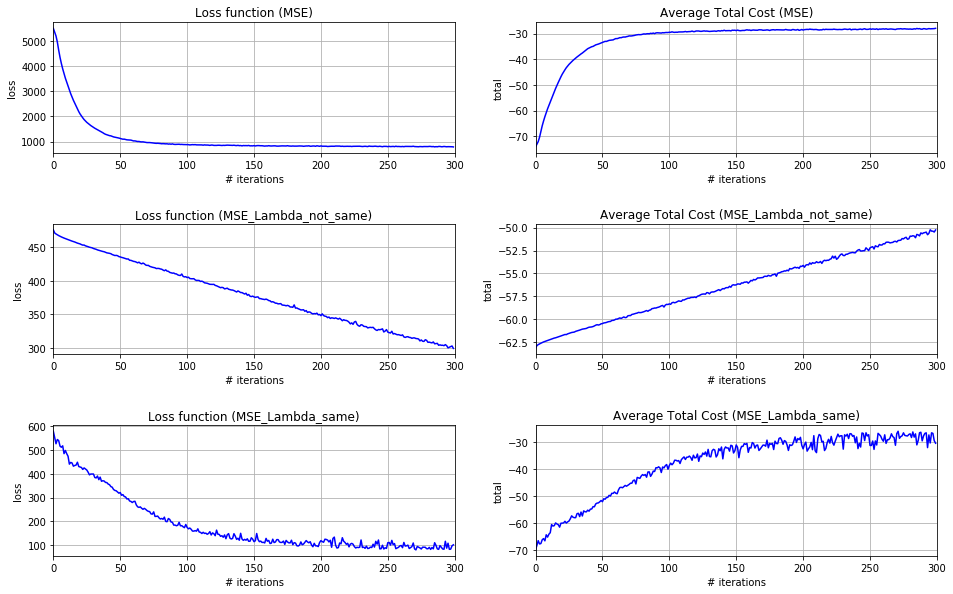

In [15]:
fig, axes = plt.subplots(nrows=len(metrics), ncols=2, figsize=(13, 8))
fig.tight_layout(h_pad=5.0, w_pad=5.0)

for i, name in enumerate(sorted(metrics)):
    losses, totals, _, _ = metrics[name]

    # plotting losses
    ax = axes[i][0]
    utils.plot_loss_function(ax, losses, epoch, name)

    # histogram of cumulative cost per batch
    ax = axes[i][1]
    utils.plot_average_total_cost(ax, totals, epoch, name)